# LCA of Smartphone production from different countries (Calculation)


This code performs an LCA on the production of single unit of smartphone.

The goal and scope of this LCA are to compare the environmental impacts associated with the production of smartphones. 

The functional unit chosen for this study is "one unit of a smartphone", and the system boundary includes raw material acquisition and manufacturing processes. 

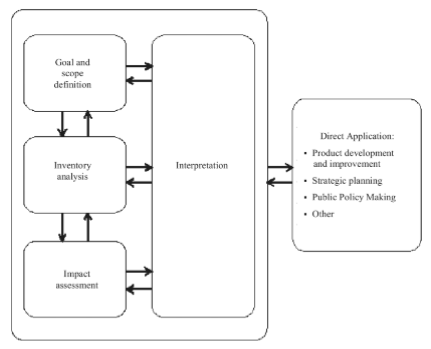


# 1. Setting Up 
Here we need proper packages, databases to conduct LCA. 

We will conduct three steps which are  


(1) Importing relevant packages, 

(2) Creating project and import database

(3) Import LCI data

### 1-1. Importing the Relevant packages

This code utilize [Brightway2](https://brightway.dev/), which is an open-source software package based on Python, used for conducting LCA. 

Below is the code for importing the necessary packages including Brightway2.

In [1]:
# import the packages
import bw2data as bd # the data handling brightway package
import bw2io as bi # the data input out package, used to import ecoinvent
import bw2calc as bc # the package that does the math
import bw2analyzer as bwa # used for the iterative calculations
from brightway2 import *

# Impport basic libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

### 1-2. Importing Ecoinvent Database

The code sets "myproject" as the current project and imports the [Ecoinvent](https://ecoinvent.org/database/) database from a specified path, applies processing strategies, and saves the data. 

It also lists available databases, including various versions of Ecoinvent.

In [2]:
bd.projects.set_current("myproject")
bd.databases

Databases dictionary with 5 object(s):
	DB_Name
	Electric Machines
	biosphere3
	ecoinvent 3.9 cutoff
	ecoinvent 3.91 cutoff

In [10]:
path = r"C:\Users\User\Song\ecoinvent 3.9.1_cutoff_ecoSpold02\datasets"
ei = SingleOutputEcospold2Importer(path, "ecoinvent")
ei.apply_strategies()
ei.write_database()

Extracting ecospold2 files:
0% [##############################] 100% | ETA: 00:00:00 | Item ID: fffede58-fed2-5
Total time elapsed: 00:05:48


Title: Extracting ecospold2 files:
  Started: 06/17/2024 14:26:29
  Finished: 06/17/2024 14:32:17
  Total time elapsed: 00:05:48
  CPU %: 12.60
  Memory %: 40.47
Extracted 21238 datasets in 350.09 seconds
Applying strategy: normalize_units
Applying strategy: update_ecoinvent_locations
Applying strategy: remove_zero_amount_coproducts
Applying strategy: remove_zero_amount_inputs_with_no_activity
Applying strategy: remove_unnamed_parameters
Applying strategy: es2_assign_only_product_with_amount_as_reference_product
Applying strategy: assign_single_product_as_activity
Applying strategy: create_composite_code
Applying strategy: drop_unspecified_subcategories
Applying strategy: fix_ecoinvent_flows_pre35
Applying strategy: drop_temporary_outdated_biosphere_flows
Applying strategy: link_biosphere_by_flow_uuid
Applying strategy: link_internal_technosphere_by_composite_code
Applying strategy: delete_exchanges_missing_activity
Applying strategy: delete_ghost_exchanges
Applying strategy: remove_un

Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:39


Title: Writing activities to SQLite3 database:
  Started: 06/17/2024 14:32:32
  Finished: 06/17/2024 14:33:12
  Total time elapsed: 00:00:39
  CPU %: 38.90
  Memory %: 36.45
Created database: ecoinvent


Brightway2 SQLiteBackend: ecoinvent

### 1-3. Importing LCI data

The script imports LCI data from an Excel file using Brightway2 and cleans it by removing empty entries.


It then matches the data to existing databases like ecoinvent and the biosphere for complete integration.


Finally, it displays statistics on the data, highlighting any unlinked exchanges.

In [86]:
# Import the excel LCI for a NMC cells
filepath = r"C:\Users\User\Song\LCI_Example - 2.xlsx" # path to excel LCI
em_importer = bi.ExcelImporter(filepath) # create importer object

# Check for empty cells in Excel and remove (thanks to Romain Sacchi)
for x in em_importer.data:
        for k, v in list(x.items()):
            if not v:
                del x[k]

em_importer.apply_strategies() # apply strategies to process the excel data

# we link imported activities to one another first, if needed
# on the basis of their name, unit and location
em_importer.match_database(fields=["name", "unit", "location"])

# then we link to ecoinvent for the remaining unlinked technosphere exchanges
# on the basis of their name, reference product, unit and location
em_importer.match_database('ecoinvent 3.91 cutoff',  fields=["reference product", "name", "unit", "location"])

# and then we link emission flows to the biosphere database
em_importer.match_database('biosphere3',  fields=["name", "unit", "categories"])

# shows stats about unlinked exchanged
em_importer.statistics()

Extracted 1 worksheets in 0.04 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 5.75 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
5 datasets
40 exchanges
0 unlinked exchanges

(5, 40, 0)

Write another database with activity

In [87]:
em_importer.write_database()
ems = bd.Database('Smartphone') #create object
list([act for act in ems])
India_act = ems.search('India')[0]
Brazil_act = ems.search('Brazil')[0]
Europe_act = ems.search('Europe')[0]
US_act = ems.search('USA')[0]
China_act = ems.search('China')[0]

Writing activities to SQLite3 database:
0% [#####] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 06/17/2024 15:53:50
  Finished: 06/17/2024 15:53:50
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 23.17
Created database: Smartphone


# 2. Selecting an Impact Category Method

Impact categories are classifications in LCA that represent different types of environmental impacts, such as climate change, acidification, or eutrophication, and are used to assess the environmental performance of products or systems.

The script filters methods from the Brightway2 bd.methods that match the criteria "ReCiPe 2016 v1.03, midpoint (E) no LT" and stores them in us_meth.

It then iterates over us_meth, extracting and printing the impact category name and its corresponding unit for each method.

This process also identifies the units of measurement used for specific impact categories in the selected method set.

In [73]:
us_meth=[met for met in bd.methods if 'ReCiPe 2016 v1.03, midpoint (E) no LT' in met[0] ]
us_meth = us_meth
print(us_meth)

[('ReCiPe 2016 v1.03, midpoint (E) no LT', 'acidification: terrestrial no LT', 'terrestrial acidification potential (TAP) no LT'), ('ReCiPe 2016 v1.03, midpoint (E) no LT', 'climate change no LT', 'global warming potential (GWP1000) no LT'), ('ReCiPe 2016 v1.03, midpoint (E) no LT', 'ecotoxicity: freshwater no LT', 'freshwater ecotoxicity potential (FETP) no LT'), ('ReCiPe 2016 v1.03, midpoint (E) no LT', 'ecotoxicity: marine no LT', 'marine ecotoxicity potential (METP) no LT'), ('ReCiPe 2016 v1.03, midpoint (E) no LT', 'ecotoxicity: terrestrial no LT', 'terrestrial ecotoxicity potential (TETP) no LT'), ('ReCiPe 2016 v1.03, midpoint (E) no LT', 'energy resources: non-renewable, fossil no LT', 'fossil fuel potential (FFP) no LT'), ('ReCiPe 2016 v1.03, midpoint (E) no LT', 'eutrophication: freshwater no LT', 'freshwater eutrophication potential (FEP) no LT'), ('ReCiPe 2016 v1.03, midpoint (E) no LT', 'eutrophication: marine no LT', 'marine eutrophication potential (MEP) no LT'), ('ReCiPe

In [103]:
for method in us_meth:
    impact= method
    unit = bd.methods.get(method).get('unit')
    print(impact)
    print(unit)

('ReCiPe 2016 v1.03, midpoint (E) no LT', 'acidification: terrestrial no LT', 'terrestrial acidification potential (TAP) no LT')
kg SO2-Eq
('ReCiPe 2016 v1.03, midpoint (E) no LT', 'climate change no LT', 'global warming potential (GWP1000) no LT')
kg CO2-Eq
('ReCiPe 2016 v1.03, midpoint (E) no LT', 'ecotoxicity: freshwater no LT', 'freshwater ecotoxicity potential (FETP) no LT')
kg 1,4-DCB-Eq
('ReCiPe 2016 v1.03, midpoint (E) no LT', 'ecotoxicity: marine no LT', 'marine ecotoxicity potential (METP) no LT')
kg 1,4-DCB-Eq
('ReCiPe 2016 v1.03, midpoint (E) no LT', 'ecotoxicity: terrestrial no LT', 'terrestrial ecotoxicity potential (TETP) no LT')
kg 1,4-DCB-Eq
('ReCiPe 2016 v1.03, midpoint (E) no LT', 'energy resources: non-renewable, fossil no LT', 'fossil fuel potential (FFP) no LT')
kg oil-Eq
('ReCiPe 2016 v1.03, midpoint (E) no LT', 'eutrophication: freshwater no LT', 'freshwater eutrophication potential (FEP) no LT')
kg P-Eq
('ReCiPe 2016 v1.03, midpoint (E) no LT', 'eutrophication:

# 3. Conduct LCA

Here we will conduct LCA.

We will conduct three steps which are  

(1) Initialization and Setup


(2) Calculation and Looping 


(3) Creating a DataFrame


### 3-1. Initialization and Setup:

"result = []:" This list will store the results of the LCA calculations.

"activity = [India_act, Brazil_act, Europe_act, US_act, China_act]:" This list contains different activity datasets representing various geographical regions or processes (e.g., activities in India, Brazil, Europe, the US, and China).

In [ ]:
result = []
activity = [India_act, Brazil_act, Europe_act, US_act, China_act]

### 3-2. Calculation and Looping :

The outer loop iterates over each activity in the activity list.

The inner loop iterates over each method in us_meth, which contains specific LCA impact assessment methods, such as "ReCiPe 2016 v1.03, midpoint (E) no LT."

For each combination of activity and method, an LCA calculation is performed:

"lca = bc.LCA({act:1}, method):" Initializes the LCA object for a specific activity and method, where act is the activity, and method is the impact assessment method.

"lca.lci():" Performs the Life Cycle Inventory (LCI) analysis, which calculates the flows of resources and emissions associated with the activity.

"lca.lcia():" Performs the Life Cycle Impact Assessment (LCIA), which calculates the potential environmental impacts using the specified method.

"result.append({'name' : act['name'], 'Score':lca.score, 'Impact Category':method, 'unit':bd.methods.get(method).get('unit')}):" For each combination of activity and method, the code stores the results in the result list.

In [105]:
for act in activity:
    for method in us_meth:
        # perform lca for nmc cells at pack level
        lca = bc.LCA({act:1}, method)
        lca.lci()
        lca.lcia()
        result.append({'name' : act['name'],
                        'Score':lca.score,
                        'Impact Category':method,
                        'unit':bd.methods.get(method).get('unit')})

### 3-3. Creating a DataFrame:

"result_df = pd.DataFrame(result):" Converts the list of results into a Pandas DataFrame, making it easier to analyze and visualize the data.

In [106]:
result_df = pd.DataFrame(result)
result_df

,name,Score,Impact Category,unit
0,India,0.127566,"(ReCiPe 2016 v1.03, midpoint (E) no LT, acidif...",kg SO2-Eq
1,India,36.491312,"(ReCiPe 2016 v1.03, midpoint (E) no LT, climat...",kg CO2-Eq
2,India,0.159025,"(ReCiPe 2016 v1.03, midpoint (E) no LT, ecotox...","kg 1,4-DCB-Eq"
3,India,970.737711,"(ReCiPe 2016 v1.03, midpoint (E) no LT, ecotox...","kg 1,4-DCB-Eq"
4,India,139.131102,"(ReCiPe 2016 v1.03, midpoint (E) no LT, ecotox...","kg 1,4-DCB-Eq"
...,...,...,...,...
85,China,0.000025,"(ReCiPe 2016 v1.03, midpoint (E) no LT, ozone ...",kg CFC-11-Eq
86,China,0.071784,"(ReCiPe 2016 v1.03, midpoint (E) no LT, partic...",kg PM2.5-Eq
87,China,0.086541,"(ReCiPe 2016 v1.03, midpoint (E) no LT, photoc...",kg NOx-Eq
88,China,0.089941,"(ReCiPe 2016 v1.03, midpoint (E) no LT, photoc...",kg NOx-Eq


# 4. Exporting the data

In [109]:
result_df.to_csv('result.csv', index=False)

print("DataFrame exported to 'result.csv' successfully.")

DataFrame exported to 'result.csv' successfully.
